In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

# Make plots inline
%matplotlib inline

In [2]:
# Training points are in [0,1] every 1/999
train_x = Variable(torch.linspace(0, 1, 1000))
# Function to model is sin(4*pi*x)
# Gaussian noise from N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
# We use exact GP inference for regression
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(0, 1)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# The likelihood output is a Gaussian with predictive mean and variance
likelihood = GaussianLikelihood()
# Initialize our model
model = GPRegressionModel(train_x.data, train_y.data, likelihood)

In [4]:
# Optimize the model
model.train()
likelihood.train()

# Adam optimizer on both the model and likelihood parametres
optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
training_iterations = 30
for i in range(training_iterations):
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(train_x)
    # Calc loss and backprop derivatives
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.data[0]))
    optimizer.step()

Iter 1/30 - Loss: 1.155
Iter 2/30 - Loss: 1.092
Iter 3/30 - Loss: 1.043
Iter 4/30 - Loss: 1.004
Iter 5/30 - Loss: 0.972
Iter 6/30 - Loss: 0.951
Iter 7/30 - Loss: 0.938
Iter 8/30 - Loss: 0.932
Iter 9/30 - Loss: 0.906
Iter 10/30 - Loss: 0.875
Iter 11/30 - Loss: 0.825
Iter 12/30 - Loss: 0.760
Iter 13/30 - Loss: 0.679
Iter 14/30 - Loss: 0.574
Iter 15/30 - Loss: 0.454
Iter 16/30 - Loss: 0.331
Iter 17/30 - Loss: 0.213
Iter 18/30 - Loss: 0.103
Iter 19/30 - Loss: 0.012
Iter 20/30 - Loss: -0.056
Iter 21/30 - Loss: -0.108
Iter 22/30 - Loss: -0.134
Iter 23/30 - Loss: -0.148
Iter 24/30 - Loss: -0.132
Iter 25/30 - Loss: -0.122
Iter 26/30 - Loss: -0.113
Iter 27/30 - Loss: -0.105
Iter 28/30 - Loss: -0.128
Iter 29/30 - Loss: -0.133
Iter 30/30 - Loss: -0.151


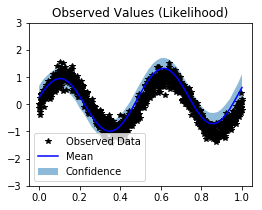

In [5]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

# Initalize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points every 0.02 in [0,1] inclusive
test_x = Variable(torch.linspace(0, 1, 51))
# Make predictions
observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get lower and upper predictive bounds
    lower, upper = rand_var.confidence_region()
    # Plot the training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Plot confidence bounds as lightly shaded region
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')